In [1]:
""" The model code from this file is adapted from the following:
https://github.com/pietrobarbiero/pytorch_explain/blob/master/experiments/elens/mnist.py

Credit to Pietro Barbiero for the original code."""

' The model code from this file is adapted from the following:\nhttps://github.com/pietrobarbiero/pytorch_explain/blob/master/experiments/elens/mnist.py\n\nCredit to Pietro Barbiero for the original code.'

In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.functional import one_hot
import imblearn
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.model_selection import StratifiedKFold, train_test_split
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
import os
from torch_explain.models.explainer import Explainer
import time
from torchmetrics.functional import precision_recall
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.linear_model import LassoCV
from torch_explain.logic.metrics import formula_consistency
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold


In [2]:
files = os.listdir("./categorisedData/")


datasets = {file : pd.read_csv("./categorisedData/" + file).set_index('PatientID') for file in files}

results_dict = {}

print(files)

print(len(datasets))

['clusteredData.csv', 'expertLabelledData.csv', 'metricExtractedData.csv', 'staticData.csv']
4


In [3]:


for file in files[:1]:

    print(f"Training {file}\n")

    data = datasets[file]

    if file == "staticData.csv":
        targetName = "deathperiod"
    else:
        targetName = "Mortality14Days"

    targetSeries = data[targetName]
    data = data.drop(columns=[targetName])


    dataTensor = torch.FloatTensor(data.to_numpy())
    targetTensor = one_hot(torch.tensor(targetSeries.values).to(torch.long)).to(torch.float)


    dataset = TensorDataset(dataTensor, targetTensor)
    train_size = int(0.8 * len(dataset))

    val_size = (len(dataset) - train_size) // 2
    test_size = len(dataset) - train_size - val_size

    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=train_size)
    val_loader = DataLoader(val_data, batch_size=val_size)
    test_loader = DataLoader(test_data, batch_size=test_size)



    n_concepts = next(iter(train_loader))[0].shape[1]
    # self.n_concepts = n_concepts


    n_classes = targetTensor.shape[1]
    # self.n_classes = n_classes

    print("Training on {} classes".format(n_classes))

    print("Num concepts: {}".format(n_concepts))
    print("Num classes: {}".format(n_classes))

    base_dir = f'./results/mimicLEN/explainer'
    os.makedirs(base_dir, exist_ok=True)

    seed_everything(40)

    n_splits = 10

    # self.n_splits = n_splits

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # self.skf = skf

    results_list = []
    feature_selection = []
    explanations = {i: [] for i in range(n_classes)}

    explanations_list = []
    scores_list = []

    x = dataTensor
    y = targetTensor


    for split, (trainval_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(),
                                                            y.argmax(dim=1).cpu().detach().numpy())):
        
        # print(x)

        # x = x.cpu()

        # print(x)
        # x = x.to(torch.device("cpu"))
        # y = y.float()
        # y = y.to(torch.device("cpu"))
        # y = one_hot(y.to(torch.int64)).to(torch.float)

        # print(x.shape)
        # print(y, y.shape)


        print(f'Split [{split + 1}/{n_splits}]')
        x_trainval, x_test = torch.FloatTensor(x[trainval_index]), torch.FloatTensor(x[test_index])
        y_trainval, y_test = torch.FloatTensor(y[trainval_index]), torch.FloatTensor(y[test_index])
        x_train_unbalanced, x_val, y_train_unbalanced, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=42)
        print(f'{len(y_train_unbalanced)}/{len(y_val)}/{len(y_test)}')


        # Rebalancing training set
        obj = imblearn.over_sampling.SMOTEN(random_state=0, n_jobs=4)

        print(sorted(Counter(torch.argmax(y_train_unbalanced, axis=1).numpy()).items()))

        x_train, y_train = obj.fit_resample(x_train_unbalanced.numpy(), torch.argmax(y_train_unbalanced, axis=1).numpy())

        print(sorted(Counter(y_train).items()))

        y_train = one_hot(torch.tensor(y_train).to(torch.long)).to(torch.float)
        x_train = torch.FloatTensor(x_train)

        train_data = TensorDataset(x_train, y_train)
        val_data = TensorDataset(x_val, y_val)
        test_data = TensorDataset(x_test, y_test)
        train_loader = DataLoader(train_data, batch_size=train_size)
        val_loader = DataLoader(val_data, batch_size=val_size)
        test_loader = DataLoader(test_data, batch_size=test_size)

        checkpoint_callback = ModelCheckpoint(dirpath=base_dir, monitor='val_loss', save_top_k=1)

        # Constructs the way that the model will be trained
        trainer = Trainer(max_epochs=200, gpus=1, auto_lr_find=True, deterministic=True,
                        check_val_every_n_epoch=1, default_root_dir=base_dir,
                        weights_save_path=base_dir, callbacks=[checkpoint_callback], enable_progress_bar=False)

        # This is the model itself, which is extended from pytorch_lightning
        model = Explainer(n_concepts=n_concepts, n_classes=n_classes, l1=1e-3, lr=0.01,
                        explainer_hidden=[20], temperature=0.7)


        start = time.time()
        trainer.fit(model, train_loader, val_loader)
        # print(f"Gamma: {model.model[0].concept_mask}")
        model.freeze()
        print("\nTesting...\n")
        model_results = trainer.test(model, test_dataloaders=test_loader)
        print("\nExplaining\n")
        results, f = model.explain_class(val_dataloaders=val_loader, train_dataloaders=train_loader, test_dataloaders=test_loader,
                                        topk_explanations=10,
                                        concept_names=data.columns)
        end = time.time()
        explanations_list.append(f)

        print(f"Explaining time: {end - start}")
        results['model_accuracy'] = model_results[0]['test_acc']
        results['extraction_time'] = end

        results_list.append(results)
        extracted_concepts = []
        all_concepts = model.model[0].concept_mask[0] > 0.5
        common_concepts = model.model[0].concept_mask[0] > 0.5
        for j in range(n_classes):
            # print(f[j]['explanation'])
            n_used_concepts = sum(model.model[0].concept_mask[j] > 0.5)
            print(f"Number of features that impact on target {j}: {n_used_concepts}")
            print(f"Explanation for target {j}: {f[j]['explanation']}")
            print(f"Explanation accuracy: {f[j]['explanation_accuracy']}")
            explanations[j].append(f[j]['explanation'])
            extracted_concepts.append(n_used_concepts)
            all_concepts += model.model[0].concept_mask[j] > 0.5
            common_concepts *= model.model[0].concept_mask[j] > 0.5

        results['extracted_concepts'] = np.mean(extracted_concepts)
        results['common_concepts_ratio'] = sum(common_concepts) / sum(all_concepts)

        # Precision, Recall, F1
        # print(x_test)
        print("Type:", type(x_test))
        y_pred = torch.argmax(model(x_test), axis=1)
        # print("Predictions:", y_pred)
        y_test_argmax = torch.argmax(y_test, axis=1)
        # print("Actual:", y_test_argmax)

        scores = [f1_score(y_test_argmax.numpy(), y_pred.numpy()), recall_score(y_test_argmax.numpy(), y_pred.numpy()), precision_score(y_test_argmax.numpy(), y_pred.numpy())]

        print(f"{file} split {split+1} scores: {scores}")

        scores_list.append(scores)


        prec_rec = precision_recall(y_pred, y_test_argmax, num_classes = n_classes)

        print(prec_rec)

        # compare against standard feature selection
        i_mutual_info = mutual_info_classif(x_trainval, y_trainval[:, 1])
        i_chi2 = chi2(x_trainval, y_trainval[:, 1])[0]
        i_chi2[np.isnan(i_chi2)] = 0
        lasso = LassoCV(cv=5, random_state=0).fit(x_trainval, y_trainval[:, 1])
        i_lasso = np.abs(lasso.coef_)
        i_mu = model.model[0].concept_mask[1]
        # print(model.model[0].concept_mask)
        df = pd.DataFrame(np.hstack([
            i_mu.numpy(),
            # i_mutual_info / np.max(i_mutual_info),
            # i_chi2 / np.max(i_chi2),
            # i_lasso / np.max(i_lasso),
        ]).T, columns=['feature importance'])
        df['method'] = 'explainer'
        # df.iloc[90:, 1] = 'MI'
        # df.iloc[180:, 1] = 'CHI2'
        # df.iloc[270:, 1] = 'Lasso'
        df['feature'] = np.hstack([np.arange(0, n_concepts)])
        feature_selection.append(df)


    results_dict[file] = [results_list, explanations_list, scores_list]


# self.feature_selection = feature_selection
# # print(self.feature_selection)

# self.df = df
# self.explanations = explanations
# self.results_list = results_list
# print(results_dict)

Global seed set to 40


Training clusteredData.csv

Training on 2 classes
Num concepts: 120
Num classes: 2
Split [1/10]
690/173/96
[(0, 666), (1, 24)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[(0, 666), (1, 666)]



  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `Da


Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.96875, 'test_acc_epoch': 0.96875}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 34.5348334312439
Number of features that impact on target 0: 12
Explanation for target 0: ~CVP_StdDev_high
Explanation accuracy: 0.6444444444444445
Number of features that impact on target 1: 6
Explanation for target 1: ~SVRI_StdDev_medium & ~SVRI_Mean_high & ~SVRI_Mean_medium & ~SVRI_Mean_very_high & ~SVRI_Mean_very_low
Explanation accuracy: 0.49206349206349204
Type: <class 'torch.Tensor'>
(tensor(0.9688), tensor(0.9688))


c:\Users\benma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split [2/10]
690/173/96
[(0, 663), (1, 27)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 663), (1, 663)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9583333134651184, 'test_acc_epoch': 0.9583333134651184}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 20.33842635154724
Number of features that impact on target 0: 8
Explanation for target 0: Arterial PaCO2_StdDev_low | Hemoglobin_StdDev_very_low | ~Hemoglobin_StdDev_very_low
Explanation accuracy: 0.49206349206349204
Number of features that impact on target 1: 10
Explanation for target 1: ~Arterial BP [Diastolic]_StdDev_medium & ~Ionized Calcium_StdDev_low
Explanation accuracy: 0.36374269005847953
Type: <class 'torch.Tensor'>
(tensor(0.9583), tensor(0.9583))
Split [3/10]
690/173/96
[(0, 669), (1, 21)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 669), (1, 669)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.96875, 'test_acc_epoch': 0.96875}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 9.75868558883667
Number of features that impact on target 0: 6
Explanation for target 0: Arterial BP [Diastolic]_StdDev_low | Arterial BP [Diastolic]_Mean_medium | Arterial BP [Diastolic]_Mean_very_low | SVR_StdDev_low | ~Arterial BP [Diastolic]_StdDev_very_high
Explanation accuracy: 0.48663101604278075
Number of features that impact on target 1: 7
Explanation for target 1: ~Arterial BP Mean_StdDev_medium & ~Arterial PaCO2_StdDev_medium & ~Arterial pH_StdDev_very_low & ~Ionized Calcium_Mean_high & ~Platelets_Mean_low & ~SVRI_Mean_low
Explanation accuracy: 0.5805042016806723
Type: <class 'torch.Tensor'>
(tensor(0.9688), tensor(0.9688))


c:\Users\benma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split [4/10]
690/173/96
[(0, 662), (1, 28)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 662), (1, 662)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9270833134651184, 'test_acc_epoch': 0.9270833134651184}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 17.53336501121521
Number of features that impact on target 0: 5
Explanation for target 0: Arterial BP [Diastolic]_StdDev_low | Ionized Calcium_StdDev_low | ~Arterial BP [Diastolic]_StdDev_low
Explanation accuracy: 0.49206349206349204
Number of features that impact on target 1: 11
Explanation for target 1: ~Arterial BP Mean_Mean_medium & ~Arterial BP [Diastolic]_StdDev_very_high & ~Arterial pH_StdDev_medium & ~Arterial pH_Mean_very_high & ~Platelets_Mean_high
Explanation accuracy: 0.40372670807453426
Type: <class 'torch.Tensor'>
(tensor(0.9271), tensor(0.9271))
Split [5/10]
690/173/96
[(0, 661), (1, 29)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 661), (1, 661)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9375, 'test_acc_epoch': 0.9375}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 10.315515995025635
Number of features that impact on target 0: 5
Explanation for target 0: Arterial PaCO2_StdDev_medium | Arterial PaCO2_Mean_medium | ~Platelets_Mean_medium
Explanation accuracy: 0.46067415730337086
Number of features that impact on target 1: 3
Explanation for target 1: CVP_Mean_very_high & ~Arterial pH_StdDev_very_low & ~Ionized Calcium_Mean_high
Explanation accuracy: 0.47540983606557374
Type: <class 'torch.Tensor'>
(tensor(0.9375), tensor(0.9375))
Split [6/10]
690/173/96
[(0, 664), (1, 26)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 664), (1, 664)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9583333134651184, 'test_acc_epoch': 0.9583333134651184}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 152.74969744682312
Number of features that impact on target 0: 18
Explanation for target 0: Arterial BP [Systolic]_Mean_low | Arterial PaCO2_StdDev_high | CVP_Mean_very_low | Platelets_StdDev_low | Platelets_Mean_medium
Explanation accuracy: 0.46368715083798884
Number of features that impact on target 1: 4
Explanation for target 1: None
Explanation accuracy: 0
Type: <class 'torch.Tensor'>
(tensor(0.9583), tensor(0.9583))


c:\Users\benma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split [7/10]
690/173/96
[(0, 666), (1, 24)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 666), (1, 666)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9479166865348816, 'test_acc_epoch': 0.9479166865348816}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 13.906607866287231
Number of features that impact on target 0: 6
Explanation for target 0: Arterial BP [Diastolic]_StdDev_medium | Ionized Calcium_StdDev_low | SVR_Mean_low | ~SVRI_StdDev_medium
Explanation accuracy: 0.6293436293436294
Number of features that impact on target 1: 7
Explanation for target 1: ~SVRI_StdDev_very_high & ~SVRI_Mean_medium & ~SVRI_Mean_very_low
Explanation accuracy: 0.4262639315134873
Type: <class 'torch.Tensor'>
(tensor(0.9479), tensor(0.9479))
Split [8/10]
690/173/96
[(0, 665), (1, 25)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 665), (1, 665)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9583333134651184, 'test_acc_epoch': 0.9583333134651184}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 25.907658576965332
Number of features that impact on target 0: 4
Explanation for target 0: Arterial BP [Diastolic]_StdDev_medium | ~SVR_StdDev_very_high
Explanation accuracy: 0.4838709677419355
Number of features that impact on target 1: 14
Explanation for target 1: ~Arterial BP Mean_StdDev_medium & ~Arterial BP Mean_Mean_medium & ~Arterial BP [Diastolic]_StdDev_very_low & ~Arterial PaCO2_StdDev_medium & ~Arterial PaCO2_Mean_low & ~Arterial pH_StdDev_very_low & ~CVP_StdDev_very_low & ~Hemoglobin_StdDev_low & ~Ionized Calcium_Mean_high & ~Platelets_StdDev_medium & ~SVRI_StdDev_medium
Explanation accuracy: 0.4866310160427807
Type: <class 'torch.Tensor'>
(tensor(0.9583), tensor(0.9583))


c:\Users\benma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split [9/10]
690/173/96
[(0, 669), (1, 21)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 669), (1, 669)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9583333134651184, 'test_acc_epoch': 0.9583333134651184}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [74]:
columns = []

columns.append("dataset")

x = files[0]

print(x)

for n in range(n_splits):
    # print(x,n)
    columns.extend([str(j + "_split_" + str(n)) for j in results_dict[x][0][n]])
    

        
    for k in range(len(results_dict[x][1][n])):
        columns.extend([str(j + "_split_" + str(n)) for j in results_dict[x][1][n][k]])

    print(columns)


# print(columns)

data = []

for x in results_dict:
    row = []
    row.append(x)
    for n in range(n_splits):
        # print(x,n)
        row.extend(results_dict[x][0][n].values())
        
        # print(columns)
                
        for k in range(len(results_dict[x][1][n])):
            row.extend(results_dict[x][1][n][k].values())

    data.append(row)


resultsDF = pd.DataFrame(data, columns=columns)

resultsDF


clusteredData.csv
['dataset', 'explanation_accuracy_split_0', 'explanation_fidelity_split_0', 'explanation_complexity_split_0', 'model_accuracy_split_0', 'extraction_time_split_0', 'extracted_concepts_split_0', 'common_concepts_ratio_split_0', 'target_class_split_0', 'explanation_split_0', 'explanation_accuracy_split_0', 'explanation_fidelity_split_0', 'explanation_complexity_split_0', 'target_class_split_0', 'explanation_split_0', 'explanation_accuracy_split_0', 'explanation_fidelity_split_0', 'explanation_complexity_split_0']
['dataset', 'explanation_accuracy_split_0', 'explanation_fidelity_split_0', 'explanation_complexity_split_0', 'model_accuracy_split_0', 'extraction_time_split_0', 'extracted_concepts_split_0', 'common_concepts_ratio_split_0', 'target_class_split_0', 'explanation_split_0', 'explanation_accuracy_split_0', 'explanation_fidelity_split_0', 'explanation_complexity_split_0', 'target_class_split_0', 'explanation_split_0', 'explanation_accuracy_split_0', 'explanation_fid

,dataset,explanation_accuracy_split_0,explanation_fidelity_split_0,explanation_complexity_split_0,model_accuracy_split_0,extraction_time_split_0,extracted_concepts_split_0,common_concepts_ratio_split_0,target_class_split_0,explanation_split_0,...,target_class_split_1,explanation_split_1,explanation_accuracy_split_1,explanation_fidelity_split_1,explanation_complexity_split_1,target_class_split_1,explanation_split_1,explanation_accuracy_split_1,explanation_fidelity_split_1,explanation_complexity_split_1
0,staticData.csv,0.000000,0.000000,0.0,0.757887,1.657886e+09,11.0,tensor(0.2222),0,CVP__quantile__q_0.3_high | CVP__c3__lag_2_low...,...,0,None,0.000000,0.000000,0,1,None,0.000000,0.000000,0
1,clusteredData.csv,0.485373,0.878125,4.5,0.956250,1.657886e+09,15.5,tensor(0.),0,None,...,0,Arterial BP Mean_Mean_medium | Arterial BP [Di...,0.482472,0.775000,4,1,Arterial PaCO2_StdDev_low & Arterial pH_StdDev...,0.488273,0.981250,5
2,expertLabelledData.csv,0.502413,0.857016,2.5,0.925400,1.657886e+09,18.5,tensor(0.1562),0,~CVP_Mean_very_high,...,0,Arterial_pH_Min_very_low | Heart_Rate_Min_high...,0.480812,0.813499,3,1,CVP_Min_medium & ~Potassium_Min_medium,0.524015,0.900533,2
3,metricExtractedData.csv,0.563349,0.939583,4.5,0.958333,1.657886e+09,11.0,tensor(0.2222),0,Arterial_pH_Max_low | CVP_Max_very_low | NBP_S...,...,0,CVP__root_mean_square_high | CVP__c3__lag_3_lo...,0.559599,0.920833,5,1,~CVP__mean_high & ~CVP__c3__lag_3_low & ~CVP__...,0.567100,0.958333,4


{0: ['CVP__root_mean_square_high | CVP__c3__lag_3_low | CVP__c3__lag_3_very_low | (CVP__mean_very_low & ~CVP__minimum_very_low)', 'CVP__quantile__q_0.3_high | CVP__c3__lag_2_low | ~CVP__quantile__q_0.1_low'], 1: ['~CVP__mean_high & ~CVP__c3__lag_3_low & ~CVP__c3__lag_3_very_low & ~CVP__c3__lag_1_low', 'CVP__quantile__q_0.1_low & CVP__quantile__q_0.7_very_high & ~CVP__minimum_very_low']}
['CVP__root_mean_square_high | CVP__c3__lag_3_low | CVP__c3__lag_3_very_low | (CVP__mean_very_low & ~CVP__minimum_very_low)', 'CVP__quantile__q_0.3_high | CVP__c3__lag_2_low | ~CVP__quantile__q_0.1_low']
['~CVP__mean_high & ~CVP__c3__lag_3_low & ~CVP__c3__lag_3_very_low & ~CVP__c3__lag_1_low', 'CVP__quantile__q_0.1_low & CVP__quantile__q_0.7_very_high & ~CVP__minimum_very_low']
Feature selection:      feature importance     method  feature
0                False  explainer        0
1                False  explainer        1
2                False  explainer        2
3                False  explainer    

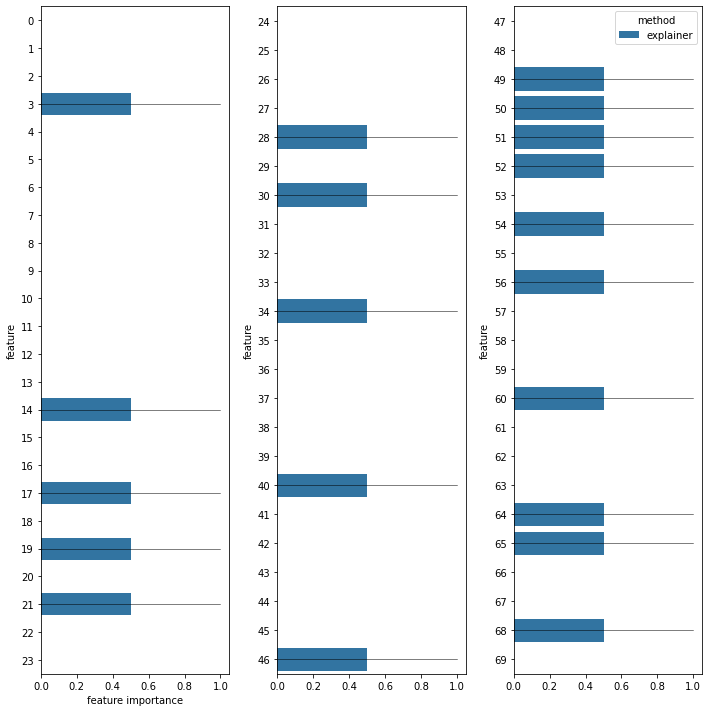

Split [1/2]
Split [2/2]
Random forest scores: 0.9405641092553931 (+/- 0.0009807759220598622)
Decision tree scores: 0.9572459986082116 (+/- 0.0010873347251217913)
Mu net scores (model): 0.9405445158481598 (+/- 0.02515715884821307)
Mu net scores (exp): 0.5207440200706117 (+/- 0.060253194407512575)


In [43]:
base_dir = f'./results/mimicLEN/explainer'

consistencies = []
print(explanations)
for j in range(n_classes):
    if explanations[j][0] is None:
        continue
    consistencies.append(formula_consistency(explanations[j]))
explanation_consistency = np.mean(consistencies)

feature_selection = pd.concat(feature_selection, axis=0)

print("Feature selection: ", feature_selection)

f1 = feature_selection[feature_selection['feature'] <= n_concepts//3]
f2 = feature_selection[(feature_selection['feature'] > n_concepts//3) & (feature_selection['feature'] <= (n_concepts*2)//3)]
f3 = feature_selection[feature_selection['feature'] > (n_concepts*2)//3]

plt.figure(figsize=[10, 10])
plt.subplot(1, 3, 1)
ax = sns.barplot(y=f1['feature'], x=f1.iloc[:, 0],
                hue=f1['method'], orient='h', errwidth=0.5, errcolor='k')
ax.get_legend().remove()
plt.subplot(1, 3, 2)
ax = sns.barplot(y=f2['feature'], x=f2.iloc[:, 0],
                hue=f2['method'], orient='h', errwidth=0.5, errcolor='k')
plt.xlabel('')
ax.get_legend().remove()
plt.subplot(1, 3, 3)
sns.barplot(y=f3['feature'], x=f3.iloc[:, 0],
            hue=f3['method'], orient='h', errwidth=0.5, errcolor='k')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'barplot_mimic.png'))
plt.savefig(os.path.join(base_dir, 'barplot_mimic.pdf'))
plt.show()

# print(feature_selection.iloc[:, 1], feature_selection.iloc[:, 0])

# plt.figure(figsize=[6, 4])
# sns.boxplot(x=feature_selection.iloc[:, 1], y=feature_selection.iloc[:, 0])
# plt.tight_layout()
# plt.savefig(os.path.join(base_dir, 'boxplot_mimic.png'))
# plt.savefig(os.path.join(base_dir, 'boxplot_mimic.pdf'))
# plt.show()


results_df = pd.DataFrame(results_list)
results_df['explanation_consistency'] = explanation_consistency
results_df.to_csv(os.path.join(base_dir, 'results_aware_mimic.csv'))
results_df


results_df.mean()

results_df.sem()

x = dataTensor
y = targetTensor

dt_scores, rf_scores = [], []
for split, (trainval_index, test_index) in enumerate(
        skf.split(x.cpu().detach().numpy(), y.argmax(dim=1).cpu().detach().numpy())):
    print(f'Split [{split + 1}/{n_splits}]')
    x_trainval, x_test = x[trainval_index], x[test_index]
    y_trainval, y_test = y[trainval_index].argmax(dim=1), y[test_index].argmax(dim=1)

    dt_model = DecisionTreeClassifier(max_depth=5, random_state=split)
    dt_model.fit(x_trainval, y_trainval)
    dt_scores.append(dt_model.score(x_test, y_test))

    rf_model = RandomForestClassifier(random_state=split)
    rf_model.fit(x_trainval, y_trainval)
    rf_scores.append(rf_model.score(x_test, y_test))

print(f'Random forest scores: {np.mean(rf_scores)} (+/- {np.std(rf_scores)})')
print(f'Decision tree scores: {np.mean(dt_scores)} (+/- {np.std(dt_scores)})')
print(f'Mu net scores (model): {results_df["model_accuracy"].mean()} (+/- {results_df["model_accuracy"].std()})')
print(
    f'Mu net scores (exp): {results_df["explanation_accuracy"].mean()} (+/- {results_df["explanation_accuracy"].std()})')


In [10]:
# Testing on non-rebalanced data

print(f1_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'))
print(recall_score(y_test_argmax.numpy(), y_pred.numpy()))
print(precision_score(y_test_argmax.numpy(), y_pred.numpy()))

0.5766791432730298
0.23529411764705882
0.16


In [19]:
precision_recall_fscore_support(y_test_argmax.numpy(), y_pred.numpy())

(array([0.97136564, 0.16      ]),
 array([0.95454545, 0.23529412]),
 array([0.9628821 , 0.19047619]),
 array([462,  17], dtype=int64))

In [20]:
print("Minority class correct: " + str(torch.sum(torch.logical_and((y_pred == 1), (y_test_argmax == 1))).item()))

Minority class correct: 4
